# Hyperparameter Optimisation for CNNs 
In this project we consider the problem of hyperparameter tuning for convolutional neural networks (CNNs) with two convolutional layers. The aim is to classify images in the Fashion MINST dataset, which consists of 70,000 labelled black & white images of fashion items split into 10 categories. 60,000 of these observations are used for training and 10,000 for testing. We aim to optimise two hyperparameters, namely learning rate and drop out and explore two methodologies for doing this, Random Search (RS) and Bayesian Optimisation (BO). 

In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [21]:
from time import time
import numpy as np
import os
import matplotlib.pyplot as plt

In [22]:
os.getcwd()

'/Users/travis/Documents/Education/Barcelona GSE/Quarter 3/topics II/hrvoje/fashionMNIST-bayesian-optimization'

In [23]:
# Hyper parameters
num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [24]:
from CNN_test_model import test_model

#### Random Search 
In this section we use random search (RS) to tune the hyperparameters of our CNN. This involves setting intervals or sets for each of the parameters we want to vary, and then randomly sampling from the a uniform distribution over them. The best performing set of hyperparameters is then chosen for the final model. 

In [26]:
from CNN_test_model import ConvNet

In [27]:
param_dist = {'dropout': [0,1],
             'learning_rate': [0,1]}
num_iterations = 10

In [28]:
def random_search(param_dist, num_iterations):
        
    sampled_values_error = {}
    for j in list(param_dist.keys()) + ["test_error"]:
        sampled_values_error[j] = [] 
        
    for i in range(num_iterations): 
        for j in param_dist.keys():
            sampled_values_error[j].append(np.random.uniform(0,1))
        sampled_values_error["test_error"].append(test_model(sampled_values_error["dropout"][i],
                                                            sampled_values_error["learning_rate"][i])) 
        
    max_index = np.argmax(sampled_values_error["test_error"])
    final_dropout = sampled_values_error["dropout"][max_index]
    final_learning_rate = sampled_values_error["learning_rate"][max_index] 
    final_test_error = sampled_values_error["test_error"][max_index] 
    
    return sampled_values_error, final_dropout, final_learning_rate, final_test_error        

In [29]:
dictionary, dropout, learning_rate, error = random_search(param_dist, num_iterations)

Epoch [1/1], Step [100/600], Loss: 1.1901
Epoch [1/1], Step [200/600], Loss: 1.0765
Epoch [1/1], Step [300/600], Loss: 0.8828
Epoch [1/1], Step [400/600], Loss: 1.1856
Epoch [1/1], Step [500/600], Loss: 0.7489
Epoch [1/1], Step [600/600], Loss: 1.2186
Test Accuracy of the model on the 10000 test images: 61.36 %
Epoch [1/1], Step [100/600], Loss: 1.8634
Epoch [1/1], Step [200/600], Loss: 1.3925
Epoch [1/1], Step [300/600], Loss: 1.3540
Epoch [1/1], Step [400/600], Loss: 1.3158
Epoch [1/1], Step [500/600], Loss: 1.5354
Epoch [1/1], Step [600/600], Loss: 1.4928
Test Accuracy of the model on the 10000 test images: 46.83 %
Epoch [1/1], Step [100/600], Loss: 2.3403
Epoch [1/1], Step [200/600], Loss: 2.3269
Epoch [1/1], Step [300/600], Loss: 2.3219
Epoch [1/1], Step [400/600], Loss: 2.3469
Epoch [1/1], Step [500/600], Loss: 2.3499
Epoch [1/1], Step [600/600], Loss: 2.3103
Test Accuracy of the model on the 10000 test images: 9.7 %
Epoch [1/1], Step [100/600], Loss: 2.3513
Epoch [1/1], Step [20

#### Bayesian Optimisation
In this section we apply BO to optimise the learning rate and dropout in the convolutional neural network with two convolutional layers. We utilise the pyGPGO package which can be found at the following link https://github.com/hawk31/pyGPGO, which uses gaussian processes to form a posterior distribution over the function we are trying to optimise. 


In [30]:
import numpy as np
from pyGPGO.covfunc import matern32, dotProd
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

In [31]:
def bayes_optim(kernel, acquisition, param, max_iter):
    np.random.seed(1337)
    cov = kernel()
    gp = GaussianProcess(cov) 
    acq = Acquisition(mode=acquisition)
    gpgo = GPGO(gp, acq, test_model, param)
    gpgo.run(max_iter)
    return gpgo

In [32]:
param = {'learning_rate': ('cont', (0.1,1)),
        'dropout': ('cont', (0,1))}
max_iter = 10 

In [33]:
results = {} 
for kernel in [matern32, dotProd]: 
    for acquisition in ["ExpectedImprovement", "UCB"]:
        start_time = time() 
        results["results_"+kernel.__name__+"_"+acquisition] = [bayes_optim(kernel, acquisition,
                                                                         param, max_iter)]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Epoch [1/1], Step [100/600], Loss: 1.0143
Epoch [1/1], Step [200/600], Loss: 0.8258
Epoch [1/1], Step [300/600], Loss: 1.1920
Epoch [1/1], Step [400/600], Loss: 1.0917
Epoch [1/1], Step [500/600], Loss: 1.0807
Epoch [1/1], Step [600/600], Loss: 1.2197
Test Accuracy of the model on the 10000 test images: 62.91 %
Epoch [1/1], Step [100/600], Loss: 1.5203
Epoch [1/1], Step [200/600], Loss: 1.5771
Epoch [1/1], Step [300/600], Loss: 1.5899
Epoch [1/1], Step [400/600], Loss: 1.3164
Epoch [1/1], Step [500/600], Loss: 1.3260
Epoch [1/1], Step [600/600], Loss: 1.5259
Test Accuracy of the model on the 10000 test images: 48.26 %
Epoch [1/1], Step [100/600], Loss: 2.3353
Epoch [1/1], Step [200/600], Loss: 2.3289
Epoch [1/1], Step [300/600], Loss: 2.2926
Epoch [1/1], Step [400/600], Loss: 2.3205
Epoch [1/1], Step [500/600], Loss: 2.3583
Epoch [1/1], Step [600/600], Loss: 2.2916
Test Accuracy of the model on the 10000 test images: 10.39 %
ini

Epoch [1/1], Step [200/600], Loss: 0.7380
Epoch [1/1], Step [300/600], Loss: 0.7292
Epoch [1/1], Step [400/600], Loss: 0.7356
Epoch [1/1], Step [500/600], Loss: 0.6994
Epoch [1/1], Step [600/600], Loss: 0.7646
Test Accuracy of the model on the 10000 test images: 76.79 %
7      	 [0.16626451 0.10169123]. 	  0.7679 	 0.8299
Epoch [1/1], Step [100/600], Loss: 0.6638
Epoch [1/1], Step [200/600], Loss: 0.6646
Epoch [1/1], Step [300/600], Loss: 0.4500
Epoch [1/1], Step [400/600], Loss: 0.5832
Epoch [1/1], Step [500/600], Loss: 0.5450
Epoch [1/1], Step [600/600], Loss: 0.4013
Test Accuracy of the model on the 10000 test images: 80.88 %
8      	 [0.18893807 0.        ]. 	  0.8088 	 0.8299
Epoch [1/1], Step [100/600], Loss: 0.8400
Epoch [1/1], Step [200/600], Loss: 0.6451
Epoch [1/1], Step [300/600], Loss: 0.6534
Epoch [1/1], Step [400/600], Loss: 0.6385
Epoch [1/1], Step [500/600], Loss: 0.6041
Epoch [1/1], Step [600/600], Loss: 0.3650
Test Accuracy of the model on the 10000 test images: 81.28

Epoch [1/1], Step [500/600], Loss: 2.3026
Epoch [1/1], Step [600/600], Loss: 2.3026
Test Accuracy of the model on the 10000 test images: 10.0 %
3      	 [1.         0.99999927]. 	  0.1    	 0.6597
Epoch [1/1], Step [100/600], Loss: 2.3026
Epoch [1/1], Step [200/600], Loss: 2.3026
Epoch [1/1], Step [300/600], Loss: 2.3026
Epoch [1/1], Step [400/600], Loss: 2.3026
Epoch [1/1], Step [500/600], Loss: 2.3026
Epoch [1/1], Step [600/600], Loss: 2.3026
Test Accuracy of the model on the 10000 test images: 10.0 %
4      	 [0.99999876 0.99999961]. 	  0.1    	 0.6597
Epoch [1/1], Step [100/600], Loss: 2.3026
Epoch [1/1], Step [200/600], Loss: 2.3026
Epoch [1/1], Step [300/600], Loss: 2.3026
Epoch [1/1], Step [400/600], Loss: 2.3026
Epoch [1/1], Step [500/600], Loss: 2.3026
Epoch [1/1], Step [600/600], Loss: 2.3026
Test Accuracy of the model on the 10000 test images: 10.0 %
5      	 [1.         0.99999388]. 	  0.1    	 0.6597
Epoch [1/1], Step [100/600], Loss: 2.3026
Epoch [1/1], Step [200/600], Lo

###### Results 
Here we present the results graphically for RS and BO for 10 iterations each. We find that in terms of reaching a high out of sample accuracy, the BO algorithms with a Matern Kernel for the GP covariance are best performing. On the other hand, Random Search performed quite badly, only reaching a high accuracy after the 8th iteration, and with a lower accuracy than the Matern BO algorithms. The worst performing of them all goes to BO with a linear kernel and UCB acquisition function. Based on our tests, the Matern kernel with the Expected Improvement acquisition function performs best for this model, set of hyperparameters and dataset. However, this should be trialled many times for a more conclusive result.


In [47]:
# saving results to pickled object
import pickle

with open('pickle jar/bayes_opt_results.pickle', 'wb') as f:
    pickle.dump(results, f)
    
with open('pickle jar/random_search_results.pickle', 'wb') as f:
    pickle.dump(dictionary, f)

In [41]:
# Compute Bayesian Optimisation best test results at each iteration 
test_matern_EP = results['results_matern32_ExpectedImprovement'][0].history
test_matern_UCB = results['results_matern32_UCB'][0].history
test_linear_EP = results['results_dotProd_ExpectedImprovement'][0].history
test_linear_UCB = results['results_dotProd_UCB'][0].history

In [42]:
# Random Search best test results at each iteration 
RS_test = dictionary["test_error"]
RS_best_test = [RS_test[0]]

for i in range(1,len(RS_test)): 
    if RS_test[i] > RS_best_test[i-1]:
        RS_best_test.append(RS_test[i])
    else:
        RS_best_test.append(RS_best_test[i-1])

In [43]:
# iterations 
iterations = list(range(1,11))

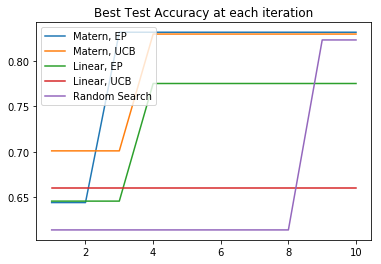

In [44]:
# Plot test results
plt.plot(iterations, test_matern_EP[1:11])
plt.plot(iterations, test_matern_UCB[1:11])
plt.plot(iterations, test_linear_EP[1:11])
plt.plot(iterations, test_linear_UCB[1:11])
plt.plot(iterations, RS_best_test)

plt.legend(['Matern, EP', 'Matern, UCB', 'Linear, EP', 'Linear, UCB', 'Random Search'],
           loc='upper left')
plt.title('Best Test Accuracy at each iteration')
plt.show()

In [45]:
from IPython.display import HTML
HTML('<img src="img/CNN_BayesianOptimization.gif">')